In [1]:
import numpy as np
from numpy import pi,sqrt,exp
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from qiskit import *
import pandas as pd
import cmath  
import seaborn as sns

n = 6 #Anzahl an Qubits
N = 2**n #Anzahl an darstellbaren Dezimalzahlen
x_res = 0.5 #Ortsaufloesung
p_res = pi/(N*x_res/2) #Impulsaufloesung
mu = 9#-8*x_res #Ortserwartungswert
m = 0.1 #Masse des Teilchens
mu2 = -1. #Impulserwartungswert
sig = 0.4 #Quadrat der Breite des Wellenpakets (Delta x)
eps = 0.05 #Zeitschritt 
#Parameter fuer die verschiedenen Potentiale:
omega = 5
om = m*omega**2/2 #m*omega^2/2
h = 10 #Hoehe der Potentialbarriere
a = 2.5 #Faktor des linearen Potentials
#Fuer 2 Teilchen gleicher Masse und entgegengesetztem Impuls
mu_teilch2 = -mu 

In [5]:
#Funktion zur Berechnung der Koeffizienten c_k fuer
#ein gausssches Wellenpaket (enthaelt die Verschiebung der QFT):
def gauss(a,xo,po):
    ck = np.array(2**n*[complex(0,0)])
    vorf = (2*pi*a)**(-2/4)
    for k in range (0,N):
        x_k = x_res*(k+(1-N)/2)
        teil1 = integrate.quadrature(lambda x: vorf*exp(-(x-xo)**2/(2*a)), x_res*(k+-N/2),x_res*(k+1-N/2), tol=1e-10)
        ck[k] = round(sqrt(teil1[0])*np.cos(po*(x_k-xo)+2*pi/N*k*(N-1)/2),10)*complex(1,0)+round(sqrt(teil1[0])*np.sin(po*(x_k-xo)+2*pi/N*k*(N-1)/2),10)*complex(0,1)
    return ck

#Funktion zur Berechnung der Koeffizienten c_k fuer
#zwei normierte gausssche Wellenpakete (2 Teilchen)
#(enthaelt die Verschiebung der QFT):
def gauss_2gleich(a,xo1,xo2,po1):
    po2 = -po1 #haben entgegengesetzten Impuls
    ck = np.array(2**n*[complex(0,0)])
    vorf = 1/2*(2*pi*a)**(-2/4) #fuer beide identisch, da gleiche Breite a (Faktor 1/2 damit Normierung erfuellt)
    for k in range(N):
        x_k = x_res*(k+(1-N)/2)
        #Erstes Teilchen an Ort xo1 mit Impuls po1:
        teil1 = integrate.quadrature(lambda x: vorf*exp(-(x-xo1)**2/(2*a)), x_res*(k+-N/2),x_res*(k+1-N/2), tol=1e-10)
        wurz1 = round(sqrt(teil1[0])*np.cos(po1*(x_k-xo1)+2*pi/N*k*(N-1)/2),10)*complex(1,0)+round(sqrt(teil1[0])*np.sin(po1*(x_k-xo1)+2*pi/N*k*(N-1)/2),10)*complex(0,1)
        #Zweites Teilchens an Ort xo2 mit Impuls -po1:
        teil2 = integrate.quadrature(lambda x: vorf*exp(-(x-xo2)**2/(2*a)), x_res*(k+-N/2),x_res*(k+1-N/2), tol=1e-10)
        wurz2 = round(sqrt(teil2[0])*np.cos(-po2*(x_k-xo2)+2*pi/N*k*(N-1)/2),10)*complex(1,0)+round(sqrt(teil2[0])*np.sin(po2*(x_k-xo2)+2*pi/N*k*(N-1)/2),10)*complex(0,1)
        ck[k]= wurz1+wurz2
    return ck

#Kontrollierte y- und z-Rotation
#mit c = Kontrollqubit, t = Zielqubit, theta = Drehwinkel:
def k_roty(c,t,theta):
    qc.ry(theta/2,t)
    qc.cx(c,t)
    qc.ry(-theta/2,t)
    qc.cx(c,t)
    return

def k_rotz(c,t,theta):
    qc.rz(theta/2,t)
    qc.cx(c,t)
    qc.rz(-theta/2,t)
    qc.cx(c,t)
    return

#Multi-Kontroll-Rotation um y- bzw. z-Achse mit
#m = Anzahl Kontrollqubits, k = array mit Kontrollqubits, t = Zielqubit, 
#theta = Drehwinkel:
def cm_roty(m, k, t, theta):
    k2 = k[:]
    del k2[-1]
    k_roty(k[-1],t,theta/2)
    cm_x(m-1,k2,k[-1],t)
    k_roty(k[-1],t,-theta/2)
    cm_x(m-1,k2,k[-1],t)
    if m > 2:
        cm_roty(m-1,k2,t,theta/2)
    else:
        k_roty(k2[0],t,theta/2)
    return

def cm_rotz(m, k, t, theta):
    k2 = k[:]
    del k2[-1]
    k_rotz(k[-1],t,theta/2)
    cm_x(m-1,k2,k[-1],t)
    k_rotz(k[-1],t,-theta/2)
    cm_x(m-1,k2,k[-1],t)
    if m > 2:
        cm_rotz(m-1,k2,t,theta/2)
    else:
        k_rotz(k2[0],t,theta/2)
    return

#Multi-Kontroll-X-Gatter mit
#plus = zusaetzlich benoetigtes Qubit, fuer dies aber dann das t qubit von cm_roty verwendet wird, m = Anzahl Kontrollqubits, k = Array von Kontrollqubits, t = Zielqubit
def cm_x(m,k,t,plus):
    if m > 2:
        k2 = k[:]
        del k2[-1]
        cm_x(m-1,k2,plus,k[-1])
        qc.ccx(k[-1],plus,t)
        cm_x(m-1,k2,plus,k[-1])
        qc.ccx(k[-1],plus,t)
    elif m > 1:
        qc.ccx(k[0],k[1],t)
    else:
        qc.cx(k[0],t)
    return

#Multi-Kontroll-U-Gatter:
def cm_u(m,k,t,theta,phi,lamb):
    if lamb!=0:
        cm_rotz(m,k,t,lamb)
    if theta!=0:  
        cm_roty(m,k,t,theta)
    if phi!=0:  
        cm_rotz(m,k,t,phi)
    return

#Berechne die 63 theta-Winkel mit polq = Betragsquadrate der N-Zustaende:
def wink_theta(polq):
    th = np.zeros(63)
    for st in range(6): #gehe alle Qubits durch
        j = N
        for i in range(2**st): #Anzahl an Winkel fuer jeweiiges Qubit
            if np.sum(polq[j-2**(6-st):j-2**(5-st)])!=0:
                s = np.sum(polq[j-2**(5-st):j])/np.sum(polq[j-2**(6-st):j-2**(5-st)])
                th[2**st-1+i] = 2*np.arctan(sqrt(s))
            elif np.sum(polq[j-2**(5-st):j]) !=0: #Fall, das Nenner 0 aber Zaehler nicht 
                th[2**st-1+i]=pi
            j -= 2**(6-st)
    return th

#Hauptfunktion zur Initialisierung des Anfangszustandes fuer 6 Qubits,
#Argument c ist ein Array mit den komplexen Vorfaktoren, das eingestellt werden soll:
def init_n6(c):
    #Umwandlung in Polarkoordinaten:
    pol = np.zeros(shape=(N,2))
    for i in range(N): pol[i] = cmath.polar(c[i])
    for i in range(N): #Korrektur fuer richtiges VZ
        if pol[i][1]<0:
            pol[i][1] += 2*pi
    #Theta-Winkel fuer Ry-Rotationen:
    quad = np.zeros(shape=N)
    for i in range(N): 
        quad[i] = pol[i][0]**2 #brauchen Betragsquadrat fuer theta
    #Berechne extern die theta-Winkel:
    th = wink_theta(quad)  
    #Phi- und Lambda Winkel fuer Rz-Rotationen:
    ph = np.zeros(32); la = np.zeros(32)
    j = N-1
    for i in range(32):
        ph[i] = pol[j][1]-pol[j-1][1]
        la[i] = -(pol[j][1]+pol[j-1][1])
        j -=2
    #------------------------------------------------------------
    #Gatter anwenden beginnend bei Qubit 5 bis Qubit 0:
    if th[0]!=0:
        qc.ry(th[0],5)
    #2 kontrollierte Rotationen:
    if th[1]!=0:
        k_roty(5,4,th[1])
    if th[2]!=0:
        qc.x(5)
        k_roty(5,4,th[2])
        qc.x(5)
    #4 zweifach kontrollierte Rotationen:
    for i in range(1,5):
        if th[2+i]!=0:
            cm_roty(2, [5,4], 3, th[2+i])
        qc.x(4)
        if i%2 == 0: qc.x(5)
    #8 dreifach kontrollierte Rotationen:
    for i in range(1,9):
        if th[6+i]!=0:
            cm_roty(3, [5,4,3], 2, th[6+i])
        qc.x(3)
        if i%2 == 0: qc.x(4)
        if i%4 == 0: qc.x(5)
    #16 vierfach kontrollierte Rotationen:
    for i in range(1,17):
        if th[14+i]!=0:
            cm_roty(4, [5,4,3,2], 1, th[14+i])
        qc.x(2)
        if i%2 == 0: qc.x(3)
        if i%4 == 0: qc.x(4)
        if i%8 == 0: qc.x(5)
    #32 fuenffach kontrollierte Rotationen
    for i in range(1,33):
        cm_u(5,[5,4,3,2,1], 0, th[30+i], ph[i-1], la[i-1])
        qc.x(1)
        if i%2 == 0: qc.x(2)
        if i%4 == 0: qc.x(3)
        if i%8 == 0: qc.x(4)
        if i%16 == 0: qc.x(5)
    return


In [6]:
#Funktion fuer die QFT:
def qft():
    q = n-1
    while q > (-1):
        qc.h(q) #Hadamard Gatter
        for c in range(0,q): #wende alle kontrollierten Phasengatter auf q an
            qc.cp(-pi/2**(q-c),c,q)
        q-=1
    for q in range(0,n//2): #Tausche die Qubits:
        qc.swap(q,n-q-1)
    return
#Funktion fuer die inverse QFT:
def inv_qft():
    for q in range(0,n//2): #Tausche die Qubits:
        qc.swap(q,n-q-1)
    q = 0    
    while q < n:
        for c in range(0,q):
            qc.cp(pi/2**(q-c),c,q)
        qc.h(q)
        q+=1
    return

In [7]:
#Funktion fuer die freie Zeitentwicklung:
def freie_bew():
    gam = eps*p_res**2/(2*m) #Gamma
    be = (1-N)/(2*n) #Beta
    i = 0
    #Globale Phase (nicht unbedingt notwendig):
    qc.p(-gam*be**2*n**2,0)
    qc.x(0)
    qc.p(-gam*be**2*n**2,0)
    qc.x(0)
    #Laufe ueber alle Qubits:
    while i < n:
        qc.p(-gam*(2**(i+1)*be*n+2**(2*i)),i) #Phasengatter auf Qubit i
        for j in range(0,i):
            qc.cp(-gam*2**(i+j+1),i,j) #Kontrolliertes Phasengatter auf i,j
        i += 1
    return

In [8]:
#lineares Potential: V(x)=a*x
def lineares_pot():
    be = (1-N)/(2*n) #Beta
    qc.p(-a*eps*x_res*be*n,0)
    qc.x(0)
    qc.p(-a*eps*x_res*be*n,0)
    qc.x(0)
    i=0
    while i < n:
        qc.p(-a*eps*x_res*2**i,i)
        i+=1
    return


#harmonisches Oszillator Potential: V(x)=0.5*m*omega*x^2
def harm_pot():
    gam2 = om*x_res**2*eps #Gamma_2
    be = (1-N)/(2*n) #Beta
    i = 0		
    qc.p(-gam2*be**2*n**2,0)	#Globale Phase (nicht unbedingt notwendig)
    qc.x(0)
    qc.p(-gam2*be**2*n**2,0)
    qc.x(0)
    while i < n:	#Laufe ueber alle Qubits
        qc.p(-gam2*(2**(i+1)*be*n+2**(2*i)),i) #Phasengatter auf Qubit i
        for j in range(0,i):
            qc.cp(-gam2*2**(i+j+1),i,j) #Kontrolliertes Phasengatter auf i,j
        i += 1
    return


#Periodische Potentialbarriere mit Breite 2^b und Hoehe h
def pot_bar():
    b = 5 
    qc.p(-h*eps,b)
    return

#Multi-Kontroll-P-Gatter fuer Funktion pot_bar2
def cm_p(m, k, t, theta):
    k2 = k[:]
    del k2[-1]
    qc.cp(theta/2,k[-1],t)
    cm_x(m-1,k2,k[-1],t)
    qc.cp(-theta/2,k[-1],t)
    cm_x(m-1,k2,k[-1],t)
    if m>2:
        cm_p(m-1,k2,t,theta/2)
    else:
        qc.cp(theta/2,k2[0],t)
    return

#Potentialbarriere bei k = 33 = 100001 mit Hoehe h
def pot_bar2():
    qc.x(1); qc.x(2); qc.x(3); qc.x(4)
    cm_p(5,[5,4,3,2,1],0,-h*eps)
    qc.x(1); qc.x(2); qc.x(3); qc.x(4)
    return

In [9]:
T = 25 #Anzahl an Zeitschritten
spalten = np.arange(T) #Zeitpunkte
zeilen = np.linspace(-(N-1)/2,(N-1)/2,N) #Ortspunkte

q = QuantumRegister(n) #Erstelle Quantenregister
qc = QuantumCircuit(q) #Erstelle Quantenschaltkreis
#ort = gauss_2gleich(sig,mu_teilch2,mu,x_res) #Funktion fuer zwei entgegenlaufende Teilchen gleicher Masse
ort = gauss(sig, mu, mu2) #Vorfaktoren fuer Anfangswellenfunktion berechnen

#Anfangszustand im Quantenregister einstellen:
qc.initialize(ort,q) 
#Alternative: 
#init_n6(ort)

#Simulatoreinstellungen:
shots = 1	#Fuer Simulation mit statevector reicht 1 Durchlauf
sim = Aer.get_backend('aer_simulator') 
result = execute(qc,sim,shots=shots).result() 
#Anfangszustand speichern in state[0]:
qc_init = qc.copy() #messe in einem 'kopierten' Schaltkreis die Werte
qc_init.save_statevector()
startzus = sim.run(qc_init).result().get_statevector()
state = np.array(N*(T+1)*[complex(0,0)]).reshape(T+1, N)
state[0] = pd.Series(startzus,index=zeilen)

#Fuehre die Zeitschritte durch:
for i in range(T):
    #hier kann Potential ausgewaehlt werden:
    #lineares_pot()#
    #pot_bar()
    harm_pot()
    #pot_bar2()
    qft()  #QFT
    freie_bew()  #Zeitentwicklung der freien Bewegung
    inv_qft()  # inverse QFT
    #Zustand speichern in state[i+1]:
    qc_init = qc.copy() 
    qc_init.save_statevector()
    state[i+1] = sim.run(qc_init).result().get_statevector()

#Ergebnisse der Wahrscheinlichkeitsverteilung aller Zeitschritte werden im pandas dataframe erg gespeichert:
liste = []
for i in range(T+1):
    liste.append(pd.Series(state[i],index=zeilen))
erg = pd.concat(liste,axis=1)
def wk(psi):
    return abs(psi)**2 #berechne aus Wellenfunktion die Wahrscheinlichkeit
erg = erg.apply(wk)

Text(0.5, 1, 'Variablen: n = 6, x_res = 0.500, $\\epsilon$= 0.050, x0 = 9.000, p0 = -1.000, $(\\Delta x)^2$=0.400\n m= 0.100, $\\omega$=5.000, $a=2.500$, $h=10.000$\n')

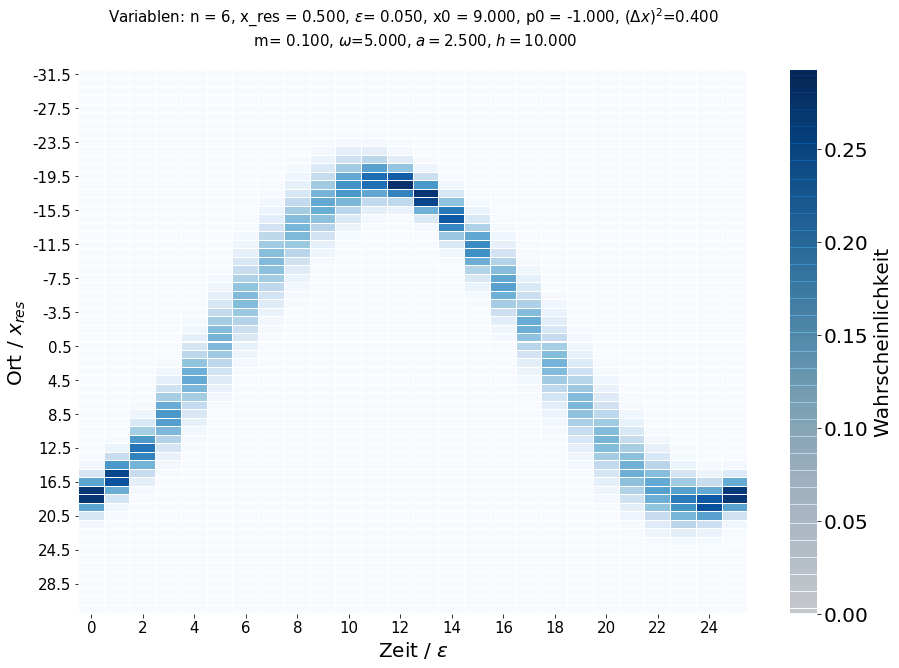

In [10]:
#Die Ergebnisse aus erg werden mit seaborn visualisiert:
plt.figure(figsize=(15,10))
ax = sns.heatmap(erg,cmap='Blues',lw=0.01, yticklabels=4,xticklabels = 2, \
                 cbar_kws={'label': 'Wahrscheinlichkeit','drawedges': True})

ax.figure.axes[-1].yaxis.label.set_size(20) #labelsize colorbar
plt.yticks(rotation=0,size=15) 
plt.xticks(size=15)
ax.set_xlabel('Zeit / $\epsilon$',fontsize=20)
ax.set_ylabel('Ort / $x_{res}$',fontsize=20)
ax.collections[0].colorbar.ax.tick_params(labelsize=20)
ax.set_title('Variablen: n = %d, x_res = %.3f, $\epsilon$= %.3f, x0 = %.3f, p0 = %.3f, \
$(\Delta x)^2$=%.3f\n m= %.3f, $\omega$=%.3f, $a=%.3f$, $h=%.3f$\n' %(n,x_res,eps,mu,mu2,sig,m,omega,a,h),fontsize=15)

